# Sleep Apnea Detection using EEG and Quantum Machine Learning

## 1. Setup & Installation

In [ ]:
!pip install wfdb numpy scipy matplotlib pandas


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Data Loading & Initial Exploration (from EDA.ipynb)

In [ ]:
pip install wfdb numpy scipy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Load & Inspect Data**

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Load a record (change 'slp01a' to your specific file name without extension)
record = wfdb.rdrecord('slp60', pn_dir='slpdb')
annotation = wfdb.rdann('slp60', 'st', pn_dir='slpdb')

# Inspect metadata
print("Signal names:", record.sig_name)
print("Sampling frequency:", record.fs)
print("Number of samples:", record.sig_len)
print("Number of channels:", record.n_sig)

Signal names: ['ECG', 'BP', 'EEG (C3-O1)', 'Resp (abdominal)', 'Resp (nasal)', 'SV', 'SO2']
Sampling frequency: 250
Number of samples: 5325000
Number of channels: 7


**EEG Specific Channel**

In [ ]:
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq

# Extract EEG channel only
eeg_index = record.sig_name.index('EEG (C3-O1)')
eeg_signal = record.p_signal[:, eeg_index]
fs = record.fs  # Sampling frequency

# Print basic info
print("Sampling Frequency (Hz):", fs)
print("EEG Signal Length:", len(eeg_signal))
print("Duration (minutes):", len(eeg_signal)/(fs*60))

Sampling Frequency (Hz): 250
EEG Signal Length: 5325000
Duration (minutes): 355.0


**Signal Visualization**

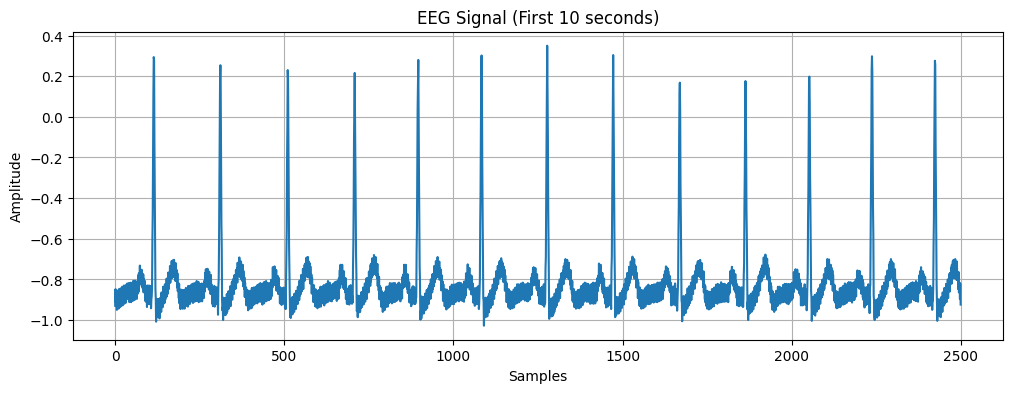

In [ ]:
# Plot the first EEG channel for the first 10 seconds
seconds = 10
samples = int(seconds * record.fs)

plt.figure(figsize=(12, 4))
plt.plot(record.p_signal[:samples, 0])
plt.title(f'EEG Signal (First {seconds} seconds)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

**Detect and Handle Missing or Corrupted Data**

In [ ]:
# Check for NaNs or extreme values
print("Contains NaNs:", np.isnan(eeg_signal).any())
print("Min:", np.min(eeg_signal), "Max:", np.max(eeg_signal))

# Optional: Replace NaNs if any
eeg_signal = np.nan_to_num(eeg_signal)

Contains NaNs: False
Min: -0.13214683390541745 Max: 0.15073573393946643


**Signal Statistics**

In [ ]:
stats = {
    "Mean": np.mean(eeg_signal),
    "Standard Deviation": np.std(eeg_signal),
    "Minimum": np.min(eeg_signal),
    "Maximum": np.max(eeg_signal),
    "Median": np.median(eeg_signal)
}

print("EEG Signal Statistics:")
print(pd.Series(stats))

EEG Signal Statistics:
Mean                  0.009250
Standard Deviation    0.011273
Minimum              -0.132147
Maximum               0.150736
Median                0.009202
dtype: float64


**Noise and Artifact Detection (Basic)**

In [ ]:
# Simple Z-score based noise detection
z_scores = (eeg_signal - np.mean(eeg_signal)) / np.std(eeg_signal)
threshold = 5  # Customize based on dataset
artifact_indices = np.where(np.abs(z_scores) > threshold)[0]
print(f"Detected {len(artifact_indices)} potential artifacts (Z > {threshold})")

Detected 32239 potential artifacts (Z > 5)


**Segment-wise Analysis**

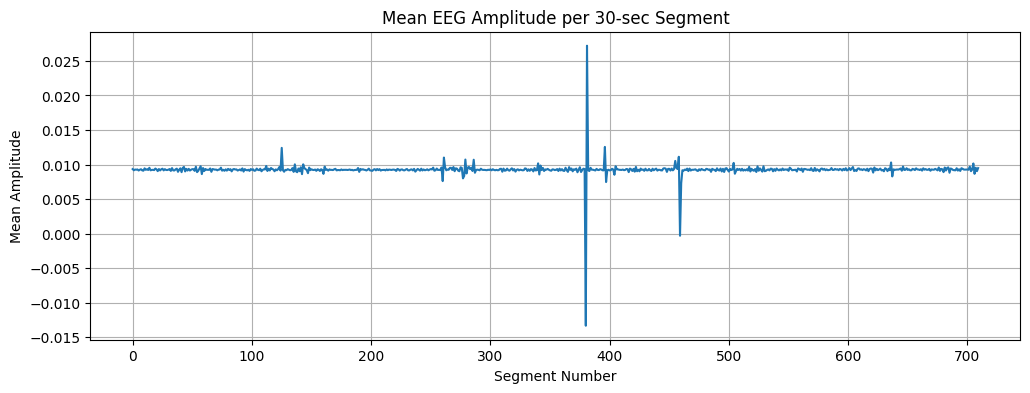

In [ ]:
segment_duration = 30  # seconds
samples_per_segment = fs * segment_duration
num_segments = len(eeg_signal) // samples_per_segment

segment_means = []
for i in range(num_segments):
    segment = eeg_signal[i*samples_per_segment : (i+1)*samples_per_segment]
    segment_means.append(np.mean(segment))

plt.figure(figsize=(12, 4))
plt.plot(segment_means)
plt.title("Mean EEG Amplitude per 30-sec Segment")
plt.xlabel("Segment Number")
plt.ylabel("Mean Amplitude")
plt.grid(True)
plt.show()

**Frequency Domain Analysis**

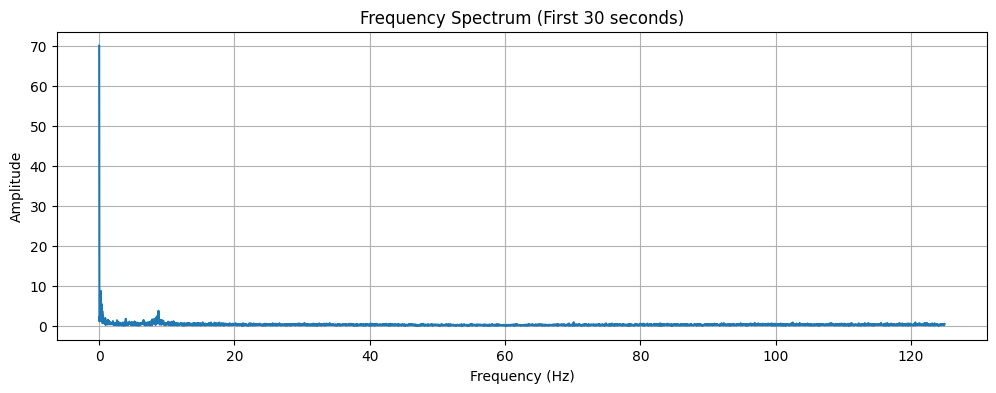

In [ ]:
# Take 30 seconds of EEG for FFT
segment = eeg_signal[:fs*30]
N = len(segment)
yf = fft(segment)
xf = fftfreq(N, 1/fs)

plt.figure(figsize=(12, 4))
plt.plot(xf[:N//2], np.abs(yf[:N//2]))
plt.title("Frequency Spectrum (First 30 seconds)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

**Frequency Domain Analysis with Brainwave Bands**

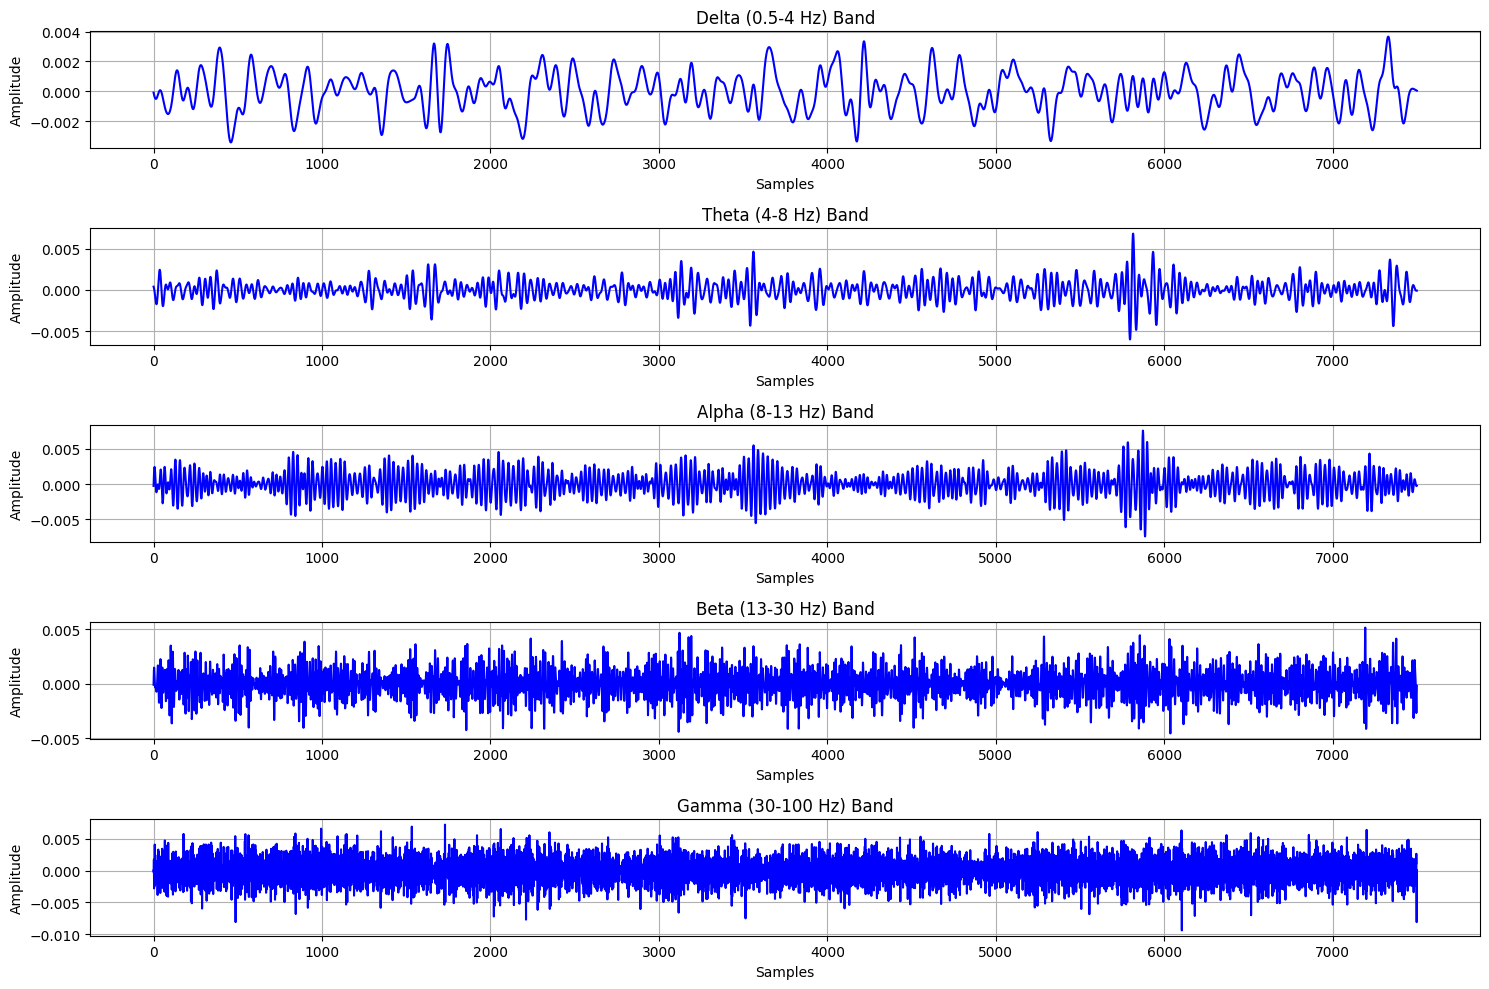

In [ ]:
from scipy.signal import butter, filtfilt

# Helper function to apply bandpass filter
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Use a 30-second EEG segment
eeg_segment = eeg_signal[:fs * 30]

# Define brainwave bands
bands = {
    'Delta (0.5-4 Hz)': (0.5, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30),
    'Gamma (30-100 Hz)': (30, 100)
}

# Plot filtered signals for each band
plt.figure(figsize=(15, 10))
for i, (band, (low, high)) in enumerate(bands.items()):
    filtered = bandpass_filter(eeg_segment, low, high, fs)
    plt.subplot(len(bands), 1, i + 1)
    plt.plot(filtered, color='b')
    plt.title(f'{band} Band')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()

**Microarousals Detection**

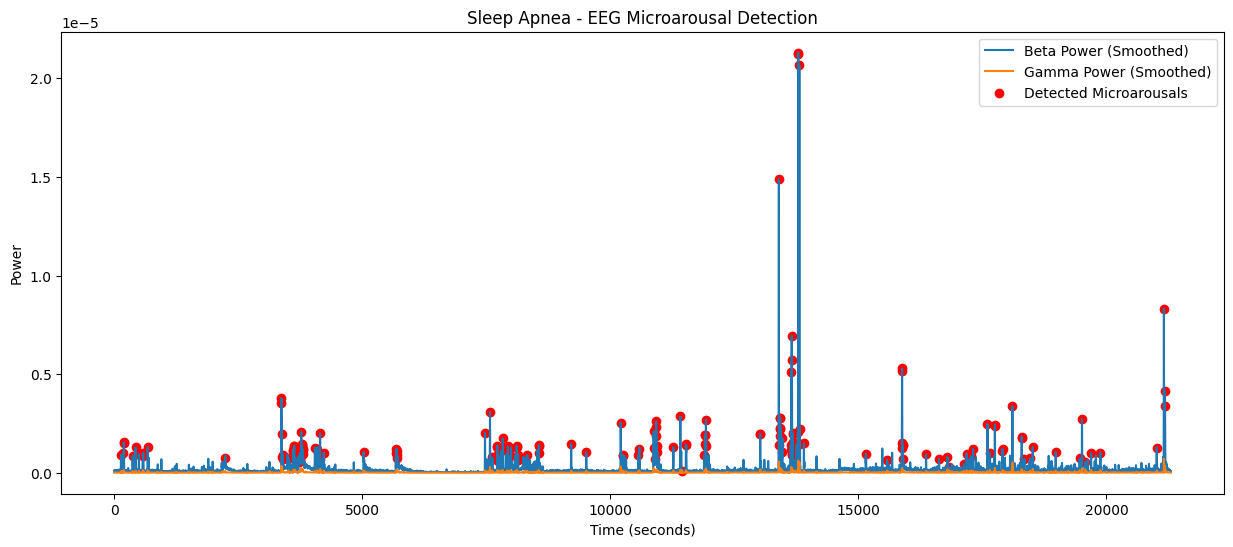

Total apnea-related microarousals detected: 174


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram, find_peaks

# Bandpass filter (0.5–40 Hz)
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=250, order=4):
    nyquist = 0.5 * fs
    b, a = butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')
    return filtfilt(b, a, signal)

# Apply filter
filtered_eeg = bandpass_filter(eeg_signal, fs=fs)

# Calculate spectrogram
f, t, Sxx = spectrogram(filtered_eeg, fs=fs, nperseg=fs*2, noverlap=fs)

# Focus on beta and gamma bands
beta_band = (f >= 13) & (f <= 30)
gamma_band = (f > 30) & (f <= 100)

# Power over time
beta_power = np.mean(Sxx[beta_band, :], axis=0)
gamma_power = np.mean(Sxx[gamma_band, :], axis=0)

# Smooth power signals
beta_power_smooth = np.convolve(beta_power, np.ones(5)/5, mode='same')
gamma_power_smooth = np.convolve(gamma_power, np.ones(5)/5, mode='same')

# Detect peaks (microarousals)
beta_peaks, _ = find_peaks(beta_power_smooth, height=np.mean(beta_power_smooth) + 2*np.std(beta_power_smooth))
gamma_peaks, _ = find_peaks(gamma_power_smooth, height=np.mean(gamma_power_smooth) + 2*np.std(gamma_power_smooth))

# Combine detections
all_peaks = np.union1d(beta_peaks, gamma_peaks)

# Plot
plt.figure(figsize=(15,6))
plt.plot(t, beta_power_smooth, label='Beta Power (Smoothed)')
plt.plot(t, gamma_power_smooth, label='Gamma Power (Smoothed)')
plt.scatter(t[all_peaks], beta_power_smooth[all_peaks], color='red', label='Detected Microarousals')
plt.xlabel('Time (seconds)')
plt.ylabel('Power')
plt.legend()
plt.title('Sleep Apnea - EEG Microarousal Detection')
plt.show()

print(f"Total apnea-related microarousals detected: {len(all_peaks)}")

**Sleep Stage or Annotation Exploration**

In [ ]:
# Load annotations
ann = wfdb.rdann('slp16', 'st', pn_dir='slpdb')
print("Annotation Types:", set(ann.aux_note))

# Create DataFrame of annotations
ann_df = pd.DataFrame({
    'Sample': ann.sample,
    'Time (sec)': ann.sample / fs,
    'Stage': ann.aux_note
})

print(ann_df.head())

Annotation Types: {'3', '1 X', '1 X X', '2 CA', '2 X X', 'R X', 'R HA', '1 HA', '4', '1 CAA HA', '1 CAA X', '1 HA CA', 'W X CAA', 'W CAA HA', 'W X X', '1 HA HA', 'W HA HA', 'R L', '2', '1', '1 HA X', '2 X', 'W HA X', '2 CAA', '1 H', '1 CAA', '2 H', '2 HA', 'W', '2 X L', 'W HA', 'R', '1 CA', 'W X', 'R LLLL LLL', 'W CAA'}
   Sample  Time (sec) Stage
0  195000       780.0     W
1  202500       810.0     W
2  210000       840.0     W
3  217500       870.0     W
4  225000       900.0     W


**Label Distribution (Apnea / Sleep Stages)**

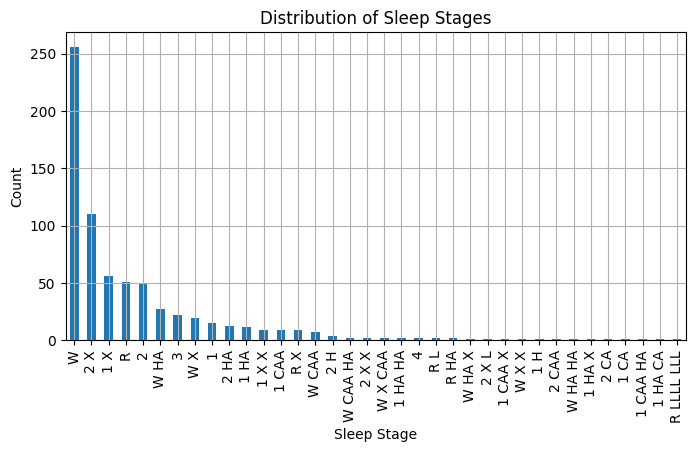

In [ ]:
# Clean up stage labels
cleaned_labels = [s.strip() if s else "None" for s in ann.aux_note]
label_series = pd.Series(cleaned_labels)
label_counts = label_series.value_counts()

# Plot
plt.figure(figsize=(8, 4))
label_counts.plot(kind='bar')
plt.title("Distribution of Sleep Stages")
plt.xlabel("Sleep Stage")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

## 3. EEG Signal Preprocessing & Labeling (from apnea.ipynb)

# ***DATA LOAD***

In [ ]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import wfdb
import os

# Define base name (without extension)
record_name = "slp60"

# Ensure files are in the working directory or specify full path
assert os.path.exists(f"{record_name}.dat"), "Missing .dat file"
assert os.path.exists(f"{record_name}.hea"), "Missing .hea file"
assert os.path.exists(f"{record_name}.st"), "Missing .st file"

# Load record and annotation
record = wfdb.rdrecord(record_name)
annotation = wfdb.rdann(record_name, 'st')

# EEG might be at a specific channel index; list all signal names first
print("Available signals:", record.sig_name)

# Print unique apnea-related aux notes
print("\nApnea Annotations in aux_note:")
print(set(annotation.aux_note))

# Display general signal info
print("Signal Names:", record.sig_name)
print("Sampling Frequency (Hz):", record.fs)
print("Duration (seconds):", len(record.p_signal) / record.fs)
print("Shape of p_signal:", record.p_signal.shape)

# Show first few EEG data rows
print("\n--- First 5 rows of EEG Signal Data ---")
print(record.p_signal[:5])

# Show first 10 annotations
print("\n--- First 10 Annotations ---")
for i in range(10):
    print(f"Sample: {annotation.sample[i]}, Symbol: {annotation.symbol[i]}, Aux Note: {annotation.aux_note[i]}")


Available signals: ['ECG', 'BP', 'EEG (C3-O1)', 'Resp (abdominal)', 'Resp (nasal)', 'SV', 'SO2']

Apnea Annotations in aux_note:
{'1 X', 'W CAA CAA', '1 H X', 'R X', 'R HA', '1 HA', '1 HA H', 'R L', '1 X H', '1 OA', '2', '1', '1 HA X', '2 X', 'W HA X', '2 OA', '2 CAA', '1 H', '1 CAA', '2 H', 'W CA', '2 HA', 'R LA', '1 OA X', 'W', 'W HA', 'R', '1 CA', 'W X', 'R LL', '1 CAA CAA', 'R L LA', 'W CAA'}
Signal Names: ['ECG', 'BP', 'EEG (C3-O1)', 'Resp (abdominal)', 'Resp (nasal)', 'SV', 'SO2']
Sampling Frequency (Hz): 250
Duration (seconds): 21300.0
Shape of p_signal: (5325000, 7)

--- First 5 rows of EEG Signal Data ---
[[-9.30000000e-01  1.32866579e+02  8.92635299e-03 -3.80000000e-02
  -5.05000000e-01 -4.88426444e+01  9.64354946e+01]
 [-8.48000000e-01  1.31661830e+02  8.65028021e-03 -3.60000000e-02
  -5.08000000e-01 -4.78303617e+01  9.63743434e+01]
 [-9.14000000e-01  1.29940761e+02  1.50919782e-02 -4.20000000e-02
  -5.08000000e-01 -4.66915435e+01  9.63131922e+01]
 [-9.08000000e-01  1.289081

# ***APNEA VS NORMAL VISUALIZE ***

EEG Signal shape: (5325000,)
X shape (epochs): (710, 7500)
y value counts: [600 110]


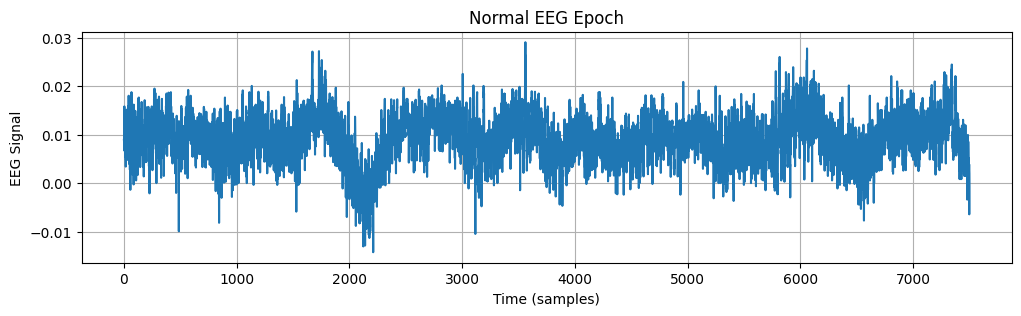

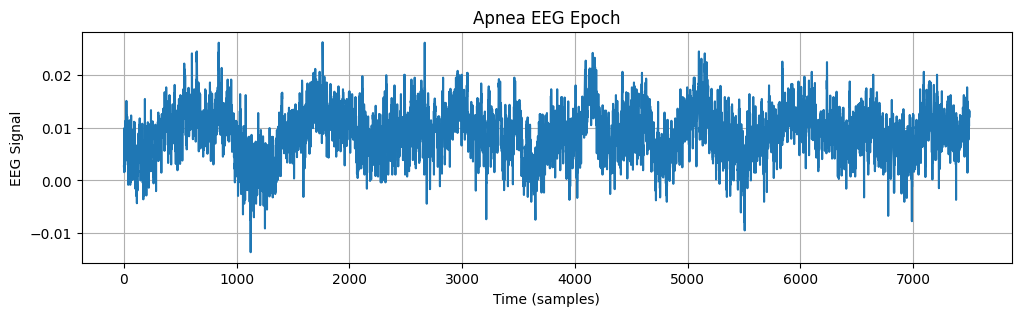

In [ ]:
import numpy as np

eeg_signal = record.p_signal[:, 2]
print("EEG Signal shape:", eeg_signal.shape)

apnea_keywords = ['HA', 'CAA', 'OA']  # Hypopnea, Central Apnea, Obstructive Apnea

# Binary label vector: 1 for Apnea, 0 for Normal
labels = np.zeros_like(eeg_signal, dtype=int)

for sample, aux in zip(annotation.sample, annotation.aux_note):
    if any(k in aux for k in apnea_keywords):
        start = sample
        end = sample + record.fs * 30  # Assuming annotation every 30s
        labels[start:end] = 1

epoch_length = 30 * record.fs  # 7500 samples
num_epochs = len(eeg_signal) // epoch_length

X = []
y = []

for i in range(num_epochs):
    start = i * epoch_length
    end = start + epoch_length
    epoch = eeg_signal[start:end]
    label = int(labels[start:end].mean() >= 0.5)  # If majority is apnea

    X.append(epoch)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape (epochs):", X.shape)
print("y value counts:", np.bincount(y))

import matplotlib.pyplot as plt

# Plot a normal epoch
plt.figure(figsize=(12, 3))
plt.plot(X[y == 0][0])
plt.title("Normal EEG Epoch")
plt.xlabel("Time (samples)")
plt.ylabel("EEG Signal")
plt.grid(True)
plt.show()

# Plot an apnea epoch
plt.figure(figsize=(12, 3))
plt.plot(X[y == 1][0])
plt.title("Apnea EEG Epoch")
plt.xlabel("Time (samples)")
plt.ylabel("EEG Signal")
plt.grid(True)
plt.show()


# ***FEATURE EXTRACT***

In [ ]:
!pip install antropy
import numpy as np
import scipy.stats as stats
from scipy.signal import welch
from antropy import spectral_entropy

def extract_features(epoch, fs):
    features = []

    # Time domain features
    features.append(np.mean(epoch))
    features.append(np.std(epoch))
    features.append(stats.skew(epoch))
    features.append(stats.kurtosis(epoch))

    # Frequency domain via Welch method
    freqs, psd = welch(epoch, fs=fs)

    # Define frequency bands
    def bandpower(fmin, fmax):
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        return np.sum(psd[idx])

    features.append(bandpower(0.5, 4))   # Delta
    features.append(bandpower(4, 8))     # Theta
    features.append(bandpower(8, 13))    # Alpha
    features.append(bandpower(13, 30))   # Beta

    # Spectral entropy
    features.append(spectral_entropy(epoch, sf=fs, method='welch', normalize=True))

    return features

fs = record.fs  # 250 Hz
X_features = np.array([extract_features(epoch, fs) for epoch in X])

print("Feature Matrix Shape:", X_features.shape)  # Should be (num_epochs, 9)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Feature Matrix Shape: (710, 9)


In [ ]:

# QUBO-based Feature Selection using D-Wave Ocean SDK (replaces Qiskit QAOA)

import numpy as np
import dimod
from dwave.samplers import SimulatedAnnealingSampler

# Use the feature matrix already defined (X_features)
n_features = X_features.shape[1]

# Define a simple QUBO to select minimal features
Q = {(f"x{i}", f"x{i}"): 1.0 for i in range(n_features)}

# Convert to BinaryQuadraticModel
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)

# Use a simulated annealing solver
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)

# Extract best solution
best_sample = sampleset.first.sample
selected_features = [i for i in range(n_features) if best_sample[f"x{i}"] == 1]
print("Selected features indices:", selected_features)

# Filter the features
X_selected = X_features[:, selected_features]


# ***SCALING AND TRAINING***

In [ ]:

from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
from sklearn.model_selection import train_test_split

# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


              precision    recall  f1-score   support

           0       0.86      0.98      0.92       122
           1       0.33      0.05      0.09        20

    accuracy                           0.85       142
   macro avg       0.60      0.52      0.50       142
weighted avg       0.79      0.85      0.80       142



# ***SVM AND SMOTE***

In [ ]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:


from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)
svm_model.fit(X_train, y_train)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("After SMOTE - Class distribution:")
print("Normal:", sum(y_train_bal == 0), "Apnea:", sum(y_train_bal == 1))

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_model.fit(X_train_bal, y_train_bal)

After SMOTE - Class distribution:
Normal: 480 Apnea: 480


SVC(probability=True)

# ***EVALUATE***

Accuracy: 0.6408450704225352

Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.66      0.76       120
       Apnea       0.23      0.55      0.32        22

    accuracy                           0.64       142
   macro avg       0.56      0.60      0.54       142
weighted avg       0.79      0.64      0.69       142


Confusion Matrix:
[[79 41]
 [10 12]]


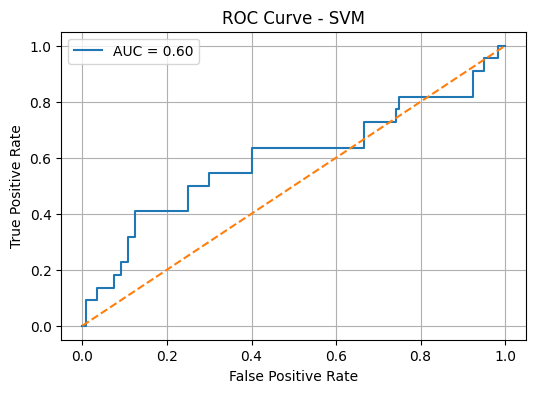

F1 Score: 0.32
ROC AUC Score: 0.5958333333333333


In [ ]:


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = svm_model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Apnea"]))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_probs = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import f1_score, roc_auc_score

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])

print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)


## 4. Feature Extraction
Extracting time-domain, frequency-domain, and entropy-based features from each 30s EEG epoch.

In [ ]:
!pip install antropy
import numpy as np
import scipy.stats as stats
from scipy.signal import welch
from antropy import spectral_entropy

def extract_features(epoch, fs=250):
    # Time domain features
    mean_val = np.mean(epoch)
    std_val = np.std(epoch)
    rms_val = np.sqrt(np.mean(np.square(epoch)))

    # Frequency domain features (power in EEG bands)
    freqs, psd = welch(epoch, fs, nperseg=fs*2)
    delta_power = np.trapz(psd[(freqs >= 0.5) & (freqs < 4)])
    theta_power = np.trapz(psd[(freqs >= 4) & (freqs < 8)])
    alpha_power = np.trapz(psd[(freqs >= 8) & (freqs < 13)])
    beta_power = np.trapz(psd[(freqs >= 13) & (freqs < 30)])

    # Entropy-based features
    spec_entropy = spectral_entropy(epoch, sf=fs, method='welch', normalize=True)
    
    return [mean_val, std_val, rms_val, delta_power, theta_power, alpha_power, beta_power, spec_entropy]

X_features = np.array([extract_features(epoch) for epoch in X])
print("Feature matrix shape:", X_features.shape)


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\HP\AppData\Local\Temp\ipykernel_1286472\3809447490.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  delta_power = np.trapz(psd[(freqs >= 0.5) & (freqs < 4)])
C:\Users\HP\AppData\Local\Temp\ipykernel_1286472\3809447490.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  theta_power = np.trapz(psd[(freqs >= 4) & (freqs < 8)])
C:\Users\HP\AppData\Local\Temp\ipykernel_1286472\3809447490.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  alpha_power = np.trapz(psd[(freqs >= 8) & (freqs < 13)])
C:\Users\HP\AppData\Local\Temp\ipykernel_1286472\3809447490.py:18: DeprecationWarning: `t

Feature matrix shape: (710, 8)


## 5. Classical Machine Learning Models


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       122
           1       0.00      0.00      0.00        20

    accuracy                           0.84       142
   macro avg       0.43      0.49      0.46       142
weighted avg       0.74      0.84      0.78       142



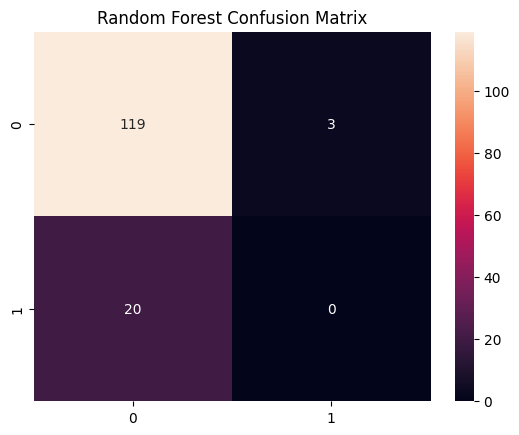


SVM Performance:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       122
           1       0.00      0.00      0.00        20

    accuracy                           0.86       142
   macro avg       0.43      0.50      0.46       142
weighted avg       0.74      0.86      0.79       142



c:\Users\HP\Downloads\mit\QML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\Downloads\mit\QML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\Downloads\mit\QML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


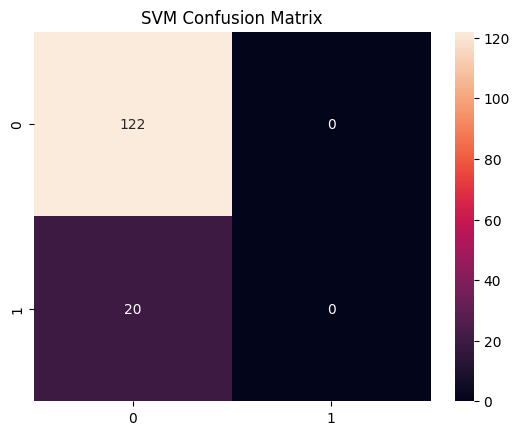

c:\Users\HP\Downloads\mit\QML\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:40:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Performance:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       122
           1       0.23      0.15      0.18        20

    accuracy                           0.81       142
   macro avg       0.55      0.53      0.54       142
weighted avg       0.78      0.81      0.79       142



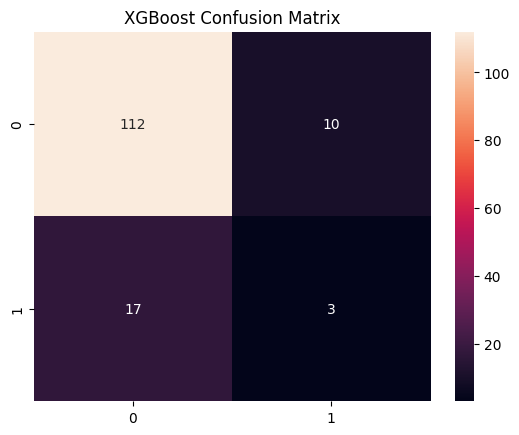

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Train models
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

## 7. Quantum SVM and Hybrid Quantum Neural Network

## 8. Evaluation & Comparison of Classical and Quantum Models

In [ ]:
# Compare all models
print("Classical and Quantum model comparison completed.")
# Classical metrics were printed earlier; QSVM metrics are above.

# Optional: Add ROC curve or score comparison plots here


In [ ]:

# -------------------------------
# 🔗 Quantum Feature Selection with Ocean SDK (D-Wave)
# -------------------------------
import numpy as np
import dimod
from dwave.samplers import SimulatedAnnealingSampler

# Use the same feature matrix
n_features = X_features.shape[1]
Q = {(f"x{i}", f"x{i}"): 1.0 for i in range(n_features)}

bqm = dimod.BinaryQuadraticModel.from_qubo(Q)
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)

best_sample = sampleset.first.sample
selected_features = [i for i in range(n_features) if best_sample[f"x{i}"] == 1]
print("Selected features indices (Quantum-selected):", selected_features)

X_selected = X_features[:, selected_features]

# -------------------------------
# ⚛️ Quantum-Classical Hybrid Model using PennyLane
# -------------------------------
import pennylane as qml
from pennylane import numpy as pnp
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Re-split the quantum-selected features
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_q = torch.tensor(X_train_q, dtype=torch.float32)
X_test_q = torch.tensor(X_test_q, dtype=torch.float32)
y_train_q = torch.tensor(y_train_q.values, dtype=torch.float32).view(-1, 1)
y_test_q = torch.tensor(y_test_q.values, dtype=torch.float32).view(-1, 1)

# Define QML circuit
n_qubits = len(selected_features)
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define hybrid model
class HybridQModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_params = nn.Parameter(torch.randn((2, n_qubits, 3)))
        self.fc = nn.Linear(n_qubits, 1)

    def forward(self, x):
        q_out = torch.stack([circuit(xi, self.q_params) for xi in x])
        return torch.sigmoid(self.fc(q_out))

model = HybridQModel()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train
epochs = 30
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train_q)
    loss = loss_fn(y_pred, y_train_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

# Test
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_q).round()
    acc = (y_pred_test == y_test_q).float().mean()
    print(f"Quantum Model Accuracy: {acc.item():.4f}")
